# Proof of concept: Using BBoxes

In [1]:
import itertools

import numpy as np
from shapely.geometry import shape, Polygon, MultiPolygon, MultiLineString
from sentinelhub import BBoxSplitter, OsmSplitter, TileSplitter, CustomGridSplitter, UtmZoneSplitter, UtmGridSplitter
from sentinelhub import WebFeatureService, BBox, Geometry, CRS, DataCollection, SHConfig

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as plt_polygon
from pyproj import Transformer
import json

In [3]:
def show_polygon(polygon):
    plt.plot(*polygon.exterior.xy)

def show_bbox(bbox):
    show_polygon(bbox.geometry)
    
def show_partition(bbox_part):
    for lst in partition:
        for bbox in lst:
            show_bbox(bbox)

In [6]:
jsonFile = "./data/sentinel2/31TGM,2021-02-23,0/tileInfo.json"
data = json.load(open(jsonFile))

for k in data.keys():
    print(k)

path
timestamp
utmZone
latitudeBand
gridSquare
datastrip
tileGeometry
tileDataGeometry
tileOrigin
dataCoveragePercentage
cloudyPixelPercentage
productName
productPath


In [7]:
crs_name = data["tileGeometry"]["crs"]["properties"]["name"].split(':')[-3]
crs_number = data["tileGeometry"]["crs"]["properties"]["name"].split(':')[-1]

print(data["tileGeometry"]["crs"]["properties"]["name"])
print(f'CRS Name: {crs_name}')
print(f'CRS Number: {crs_number}')

coordinates = data["tileGeometry"]["coordinates"][0]
print(f'Coordinates ({crs_name}:{crs_number}): {coordinates}')

transformer = Transformer.from_crs(f'{crs_name}:{crs_number}', "epsg:4326")
coordinates = [list(transformer.transform(point[0], point[1])) for point in coordinates]
coordinates = [[point[1], point[0]] for point in coordinates]
print(f'Coordinates  (EPSG:4326): {coordinates}')

urn:ogc:def:crs:EPSG:8.8.1:32631
CRS Name: EPSG
CRS Number: 32631
Coordinates (EPSG:32631): [[699960.0, 5200020.0], [809760.0, 5200020.0], [809760.0, 5090220.0], [699960.0, 5090220.0], [699960.0, 5200020.0]]
Coordinates  (EPSG:4326): [[5.626485355267178, 46.92357305783375], [7.065657132764588, 46.881459661163504], [6.9930021665949145, 45.89573525146742], [5.5794594555435, 45.936430872600674], [5.626485355267178, 46.92357305783375]]


In [8]:
search_bbox = BBox(bbox=[(6.0658, 46.1694), (6.2347, 46.2328)], crs=CRS.WGS84)
tile_catalog = Polygon([
 [5.626498040289656, 46.92356376784977],
 [5.579472762565917, 45.93643957329024],
 [6.992990020033113, 45.89574467885507],
 [7.065643441305988, 46.88145114926512],
 [5.626498040289656, 46.92356376784977]])

tile_metadata = Polygon(coordinates)

In [9]:
def outer_rectangle(polygon):
    x, y = polygon.exterior.coords.xy
    # sort coords and remove duplicate
    x = sorted(x[:-1])
    y = sorted(y[:-1])    
    
    min_x, max_x = x[0], x[3]
    min_y, max_y = y[0], y[3]
    
    polygon = ((min_x, min_y),
               (min_x, max_y),
               (max_x, max_y),
               (max_x, min_y))
    
    return Polygon(polygon)
    
def inner_rectangle(polygon):
    x, y = polygon.exterior.coords.xy
    # sort coords and remove duplicate
    x = sorted(x[:-1])
    y = sorted(y[:-1])    
    
    min_x, max_x = x[1], x[2]
    min_y, max_y = y[1], y[2]
    
    polygon = ((min_x, min_y),
               (min_x, max_y),
               (max_x, max_y),
               (max_x, min_y))
    
    return Polygon(polygon)

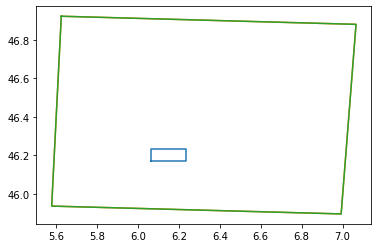

In [18]:
show_bbox(search_bbox)
show_polygon(tile_catalog)
show_polygon(tile_metadata)

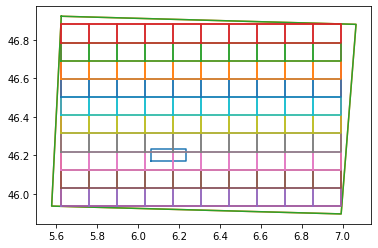

In [22]:
show_bbox(search_bbox)
show_polygon(tile_catalog)
show_polygon(tile_metadata)

inner = inner_rectangle(tile_metadata)
show_polygon(inner)
partition = BBox(inner, crs='epsg:4326').get_partition(num_x=10, num_y=10)
show_partition(partition)

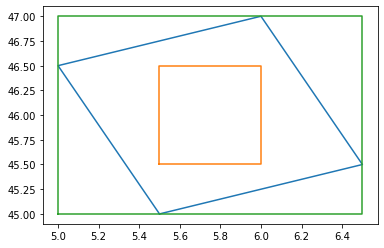

In [10]:
distorted = Polygon([
 [5.5, 45],
 [5, 46.5],
 [6, 47],
 [6.5, 45.5]])
show_polygon(distorted)

inner = inner_rectangle(distorted)
show_polygon(inner)

outer = outer_rectangle(distorted)
show_polygon(outer)